# Finding use cases for method comparison

... and for figures in paper

In [5]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-04-11T14:37:10.993892+02:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



In [6]:
import contextily as cx
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import pandas as pd
import shapely
from shapely.geometry import Point

import core  # noqa: F401
from core import utils

%watermark -w
%watermark -iv

Watermark: 2.5.0

contextily: 1.6.2
momepy    : 0.9.1
shapely   : 2.0.6
core      : 0.1.dev208+gcab4807.d20250225
geopandas : 1.0.1
folium    : 0.18.0
pandas    : 2.2.3
matplotlib: 3.9.3



In [7]:
# which methods to import
methods = [
    "original",
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "neatnet",
    "revised_manual",
]

cities = list(utils.city_fua.keys())

# read in base data
meta = utils.read_sample_data()

Read in data

In [8]:
# define city
city = "Douala"
fua = utils.city_fua[city]

geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

gdf_orig = utils.read_original(fua)
proj_crs = gdf_orig.crs

# read in data for each method
geoms = {}
for method in methods:
    gdf = utils.read_results(fua, method, proj_crs)

    # Extract vertices
    _endpoint = lambda x, gdf=gdf: shapely.get_point(  # noqa: E731
        gdf.geometry.explode(ignore_index=True), x
    )

    # _endpoint = get_endpoint(gdf)
    _endpoints = pd.concat([_endpoint(0), _endpoint(-1)]).drop_duplicates()
    vertices = gpd.GeoDataFrame(geometry=_endpoints, crs=gdf.crs)

    geoms[method] = {}
    geoms[method]["lines"] = gdf.copy()
    geoms[method]["vertices"] = vertices.copy()

For one specific use case, ...

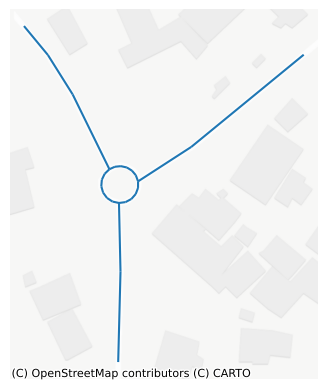

In [9]:
mybuffer = 45
mycoord = [585763.545, 448046.245]
myzoom = Point(mycoord).buffer(mybuffer, cap_style=3)

fig, ax = plt.subplots(1, 1)
geoms["original"]["lines"].clip(myzoom).plot(ax=ax)
ax.set_axis_off()
cx.add_basemap(
    ax=ax, source=cx.providers.CartoDB.Positron, crs=geoms["original"]["lines"].crs
)

Make comparison plot

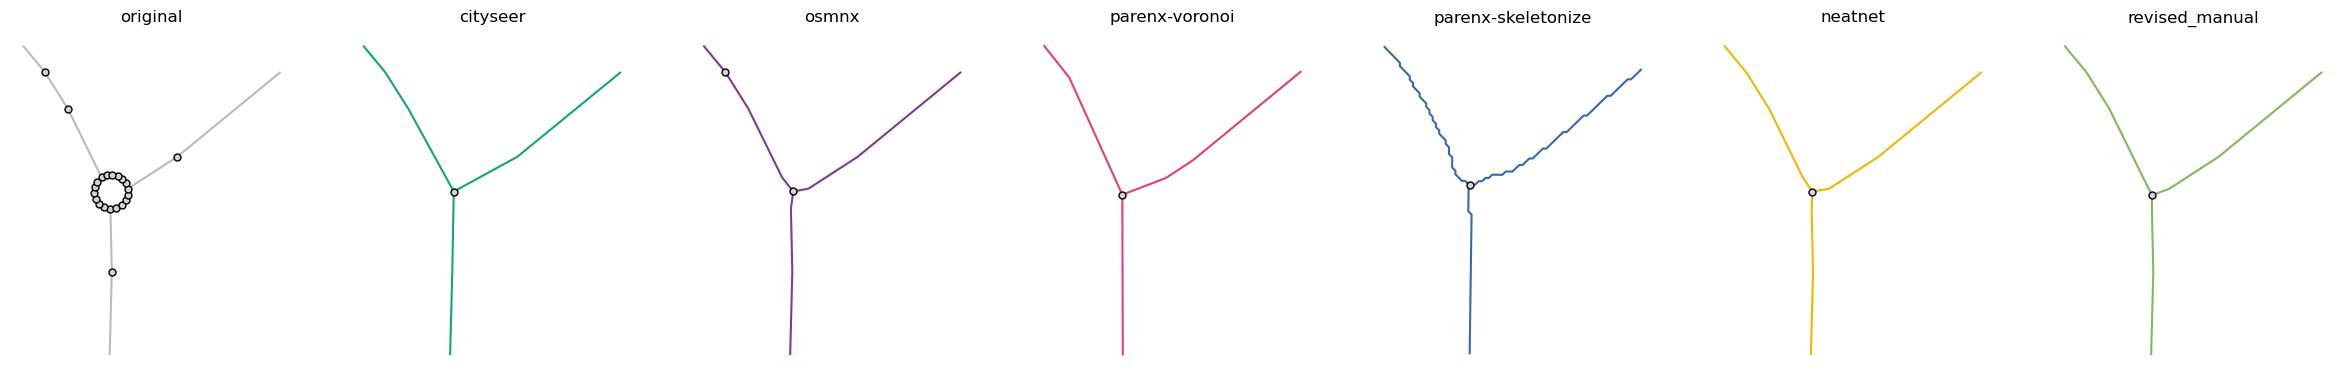

In [10]:
fig, axs = plt.subplots(1, len(methods), figsize=(30, 10))
for ax, method in zip(axs, methods, strict=False):
    lines = geoms[method]["lines"].clip(myzoom).copy()
    vertices = geoms[method]["vertices"].clip(myzoom).copy()
    lines.plot(
        ax=ax, linewidth=1.5, linestyle="-", zorder=1, color=utils.method_color[method]
    )
    vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)
    ax.set_axis_off()
    ax.set_title(method)

In [11]:
# m = gdfs["cityseer"].explore(name="cityseer", tiles="cartodb.positron", color = "red")
# gdfs["original"].explore(m=m, name="original", color = "black")
# folium.LayerControl().add_to(m)
# m